# Исследование тарифов сотовой связи

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math

try:
    data_calls = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Анализ тарифов сотовой связи/calls.csv')
    data_internet = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Анализ тарифов сотовой связи/internet.csv')
    data_messages = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Анализ тарифов сотовой связи/messages.csv')
    data_tariffs = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Анализ тарифов сотовой связи/tariffs.csv')
    data_users = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Анализ тарифов сотовой связи/users.csv')
    
except:
    data_calls = pd.read_csv('/datasets/calls.csv')
    data_internet = pd.read_csv('/datasets/internet.csv')
    data_messages = pd.read_csv('/datasets/messages.csv')
    data_tariffs = pd.read_csv('/datasets/tariffs.csv')
    data_users = pd.read_csv('/datasets/users.csv')    
    
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

### Шаг 1. Обзор и приведение данных к нужным типам 

***Таблица data_calls***

Описание данных

Таблица data_calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

В таблице с информацией о звонках 202607 записей. Пропусков значений нет.
Столбец call_date нужно сменить тип, чтобы в дальнейшем можно было использовать его как дату.

In [2]:
display(len(data_calls['id']), data_calls.head(), data_calls.describe().T) # посмотрим таблицу data_calls
data_calls.info()

202607

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [4]:
 # "Мегалайн" всегда округляет секунды до минут, поэтому добавим столбец с округлёнными минутами  по каждому звонку для расчётов
data_calls['duration_rounded'] = data_calls['duration'].apply(np.ceil) 
data_calls.head()

,id,call_date,duration,user_id,duration_rounded
0,1000_0,2018-07-25,0.00,1000,0.0
1,1000_1,2018-08-17,0.00,1000,0.0
2,1000_2,2018-06-11,2.85,1000,3.0
3,1000_3,2018-09-21,13.80,1000,14.0
4,1000_4,2018-12-15,5.18,1000,6.0


***Таблица data_internet***

Описание данных

Таблица data_internet (информация об интернет-сессиях):
-	id — уникальный номер сессии
-	mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
-	session_date — дата интернет-сессии
-	user_id — идентификатор пользователя

В таблице с информацией об интернет-сессиях 149396 записей. Пропусков значений нет.
Столбец session_date нужно сменить тип, чтобы в дальнейшем можно было использовать его как дату.

In [5]:
display(len(data_internet['id']), data_internet.head(), data_internet.describe().T) # посмотрим таблицу data_internet
data_internet.info()

149396

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


***Таблица data_messages***

Описание данных

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

В таблице с информацией о сообщениях 123036 записей. Пропусков значений нет.
Столбец message_date нужно сменить тип, чтобы в дальнейшем можно было использовать его как дату.

In [7]:
display(len(data_messages['id']), data_messages.head(), data_messages.describe().T) # посмотрим таблицу data_messages
data_messages.info()

123036

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [8]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


***Таблица data_tariffs***

Описание данных

Таблица tariffs (информация о тарифах):
-	tariff_name — название тарифа
-	rub_monthly_fee — ежемесячная абонентская плата в рублях
-	minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
-	messages_included — количество сообщений в месяц, включённых в абонентскую плату
-	mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
-	rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
-	rub_per_message — стоимость отправки сообщения сверх тарифного пакета
-	rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Таблица включает в себя условия по двум тарифам "Смарт" и "Ультра"

In [9]:
display(data_tariffs.head()) # посмотрим таблицу data_tariffs
data_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


***Таблица data_users***

Описание данных

Таблица data_users (информация о пользователях):
-	user_id — уникальный идентификатор пользователя
-	first_name — имя пользователя
-	last_name — фамилия пользователя
-	age — возраст пользователя (годы)
-	reg_date — дата подключения тарифа (день, месяц, год)
-	churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
-	city — город проживания пользователя
-	tarif — название тарифного плана

В таблице с информацией о пользователях 500 записей. Пропуски есть в столбце churn_date (дата прекращения пользования тарифом). Эти пропуски говорят о том, что на момент выгрузки данных тариф ещё действовал.
Столбцы reg_date и churn_date нужно сменить тип, чтобы в дальнейшем можно было использовать его как дату.

In [10]:
display(len(data_users['user_id']), data_users.head(), data_users.describe().T) # посмотрим таблицу data_users
data_users.info()

500

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [11]:
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


***Вывод***

Для работы получено пять разных таблиц с информацией о пользователях (data_users), об их звонках (data_calls), сообщениях(data_messages) и интернет-сессиях (data_internet), а также об условиях тарифов (data_tariffs)

Пропуски содержит только таблица data_users, но мы заменять не будем, т.к. тариф ещё действовал на момент выгрузки данных.

В таблицах data_calls, data_internet, data_messages, data_users столбцам с датами изменили тип данных на datetime.

В data_calls добавили столбец с округлёнными минутами  по каждому звонку для расчётов, т.к. "Мегалайн" всегда округляет секунды до минут. 

### Шаг 2 Формирование дополнительных датафреймов, декомпозиция исходного датафрейма.

In [12]:
data_calls['month'] = data_calls['call_date'].dt.month
data_calls.head()

,id,call_date,duration,user_id,duration_rounded,month
0,1000_0,2018-07-25,0.00,1000,0.0,7
1,1000_1,2018-08-17,0.00,1000,0.0,8
2,1000_2,2018-06-11,2.85,1000,3.0,6
3,1000_3,2018-09-21,13.80,1000,14.0,9
4,1000_4,2018-12-15,5.18,1000,6.0,12


In [13]:
# посчитаем по каждому клиенту количество совершённых звонков и израсходованных минут в каждом месяце
fun = [('duration_rounded', 'sum'), ('id','count')]

data_calls = (data_calls
            .groupby(by=['user_id', 'month'])['duration_rounded']
            .agg(fun)
            .reset_index()
           )

data_calls = data_calls.rename(
    columns={
        'duration_rounded': 'calls_sum',
        'id': 'calls_quantity'
    }
)

data_calls.head(10)

,user_id,month,calls_sum,calls_quantity
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
5,1000,10,350.0,57
6,1000,11,338.0,43
7,1000,12,333.0,46
8,1001,11,430.0,59
9,1001,12,414.0,63


In [14]:
# посчитаем количество отправленных сообщений по месяцам
data_messages['month'] = data_messages['message_date'].dt.month
data_message = (data_messages
              .pivot_table(index=['user_id', 'month'], values=['id'], aggfunc='count')
              .reset_index()
             )
data_message = data_message.rename(columns={'id': 'messages_quantity'})
data_message.head(10)

,user_id,month,messages_quantity
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [15]:
# посчитаем объём израсходованного интернет-трафика по месяцам и округлим его до Гб 
data_internet['month'] = data_internet['session_date'].dt.month
data_internet = (data_internet
              .pivot_table(index=['user_id', 'month'], values=['mb_used'], aggfunc='sum')
              .reset_index()
              )
data_internet['gb_used'] = (data_internet['mb_used'] / 1024).apply(np.ceil) # оператор округляет общую сумму за месяц
data_internet.head(10)

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0
5,1000,10,14702.49,15.0
6,1000,11,14756.47,15.0
7,1000,12,9817.61,10.0
8,1001,11,18429.34,18.0
9,1001,12,14036.66,14.0


In [16]:
# добавим столбец с объёмом включенного в абонентскую плату интернет-трафика в Гб
data_tariffs['gb_per_month_included'] = data_tariffs['mb_per_month_included'] / 1024
data_tariffs.T

,0,1
messages_included,50,1000
mb_per_month_included,15360,30720
minutes_included,500,3000
rub_monthly_fee,550,1950
rub_per_gb,200,150
rub_per_message,3,1
rub_per_minute,3,1
tariff_name,smart,ultra
gb_per_month_included,15.0,30.0


In [17]:
# соберём данные о звонках, сообщениях и интернет_трафике в одну таблицу
data = (data_calls
      .merge(data_message, how='outer')
      .merge(data_internet, how='outer')
      .merge(data_users[['user_id','tariff', 'city']], how='outer')
      .drop(['mb_used'], axis=1)
           )

data.head(15)

,user_id,month,calls_sum,calls_quantity,messages_quantity,gb_used,tariff,city
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар
5,1000,10.0,350.0,57.0,73.0,15.0,ultra,Краснодар
6,1000,11.0,338.0,43.0,58.0,15.0,ultra,Краснодар
7,1000,12.0,333.0,46.0,70.0,10.0,ultra,Краснодар
8,1001,11.0,430.0,59.0,NaN,18.0,smart,Москва
9,1001,12.0,414.0,63.0,NaN,14.0,smart,Москва


In [18]:
# добавим сюда данные по условиям соответствующего тарифа
# пропуски заменим на 0 
data = data.merge(data_tariffs, left_on=['tariff'], right_on=['tariff_name'], how='left').drop(['tariff_name'], axis=1).fillna(0)
#data.head(15)
#data.isna().sum()


In [19]:
def revenue (row):
    calls_sum = row['calls_sum']
    minutes_included = row['minutes_included']
    messages_quantity = row['messages_quantity']
    messages_included = row['messages_included']
    gb_used = row['gb_used']
    gb_per_month_included = row['gb_per_month_included']
    rub_monthly_fee = row['rub_monthly_fee']
    rub_per_gb = row['rub_per_gb']
    rub_per_message = row['rub_per_message']
    rub_per_minute = row['rub_per_minute']
    cost = 0
    
    if (calls_sum - minutes_included) > 0:
        cost = (calls_sum - minutes_included) * rub_per_minute
    
    if (messages_quantity - messages_included) > 0:
        cost = cost + (messages_quantity - messages_included) * rub_per_message
    
    if (gb_used - gb_per_month_included) > 0:
        cost = cost + (gb_used - gb_per_month_included) * rub_per_gb
    
    return (cost + rub_monthly_fee)
        
data['cost'] = data.apply(revenue, axis=1)
data.head(15)

,user_id,month,calls_sum,calls_quantity,messages_quantity,gb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,cost
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,30.0,1950.0
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,30.0,1950.0
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,30.0,1950.0
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,30.0,1950.0
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,30.0,1950.0
5,1000,10.0,350.0,57.0,73.0,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,30.0,1950.0
6,1000,11.0,338.0,43.0,58.0,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,30.0,1950.0
7,1000,12.0,333.0,46.0,70.0,10.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,30.0,1950.0
8,1001,11.0,430.0,59.0,0.0,18.0,smart,Москва,50,15360,500,550,200,3,3,15.0,1150.0
9,1001,12.0,414.0,63.0,0.0,14.0,smart,Москва,50,15360,500,550,200,3,3,15.0,550.0


In [20]:
# создадим новый датафрейм
df = data[['user_id', 'month', 'tariff', 'rub_monthly_fee', 'cost', 'calls_sum', 'calls_quantity', 'messages_quantity', 'gb_used', 'city']]
df.head(20)
#len(df['user_id'].unique())

,user_id,month,tariff,rub_monthly_fee,cost,calls_sum,calls_quantity,messages_quantity,gb_used,city
0,1000,5.0,ultra,1950,1950.0,159.0,22.0,22.0,3.0,Краснодар
1,1000,6.0,ultra,1950,1950.0,172.0,43.0,60.0,23.0,Краснодар
2,1000,7.0,ultra,1950,1950.0,340.0,47.0,75.0,14.0,Краснодар
3,1000,8.0,ultra,1950,1950.0,408.0,52.0,81.0,14.0,Краснодар
4,1000,9.0,ultra,1950,1950.0,466.0,58.0,57.0,15.0,Краснодар
5,1000,10.0,ultra,1950,1950.0,350.0,57.0,73.0,15.0,Краснодар
6,1000,11.0,ultra,1950,1950.0,338.0,43.0,58.0,15.0,Краснодар
7,1000,12.0,ultra,1950,1950.0,333.0,46.0,70.0,10.0,Краснодар
8,1001,11.0,smart,550,1150.0,430.0,59.0,0.0,18.0,Москва
9,1001,12.0,smart,550,550.0,414.0,63.0,0.0,14.0,Москва


***Вывод***

В ходе подготовки данных для дальнейшего использования в таблице: 
- data_calls добавили два столбца с количеством совершённых звонков и израсходованных минут по каждому месяцу
- data_messages добавили столбец с количеством отправленных сообщений
- data_internet добавили столбец с количеством израсходованного интернет-трафика, округлив значение до целого в большую сторону, согласно правилу расчёта оператора
- data_tariffs добавили столбец с объёмом включенного в абонентскую плату интернет-трафика в Гб, т.к. все расчёты оператор ведёт по Гб

Затем собрали данные из разных таблиц в одну и по ней посчитали по каждому пользователю в каждом месяце сумму расходов на связь.

Для дальнейшей работы создали новую таблицу с меньшим количеством столбцов.

### Шаг 3 Анализ данных.

In [21]:
df_ultra = df.query('tariff == "ultra"')
df_smart = df.query('tariff == "smart"')

print('Количество пользователей тарифа ultra -', len(df_ultra['user_id'].unique()))
print('Количество пользователей тарифа smart -', len(df_smart['user_id'].unique()))

Количество пользователей тарифа ultra - 149
Количество пользователей тарифа smart - 351


In [22]:
df_ultra.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,986.0,1262.957404,140.689268,1000.0,1143.0,1277.0,1381.00,1495.0
month,986.0,8.242394,2.882305,0.0,6.0,9.0,11.00,12.0
rub_monthly_fee,986.0,1950.000000,0.000000,1950.0,1950.0,1950.0,1950.00,1950.0
cost,986.0,2070.030426,376.015578,1950.0,1950.0,1950.0,1950.00,4800.0
calls_sum,986.0,526.089249,317.887549,0.0,282.5,518.0,751.75,1673.0
calls_quantity,986.0,73.318458,43.956739,0.0,41.0,73.5,103.75,244.0
messages_quantity,986.0,49.313387,47.806040,0.0,6.0,38.0,78.75,224.0
gb_used,986.0,19.474645,9.868057,0.0,12.0,19.0,27.00,49.0


In [23]:
df_smart.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2230.0,1246.562332,146.110501,1001.0,1121.0,1240.0,1376.0,1499.0
month,2230.0,8.343049,2.925006,0.0,6.0,9.0,11.0,12.0
rub_monthly_fee,2230.0,550.000000,0.000000,550.0,550.0,550.0,550.0,550.0
cost,2230.0,1289.641704,818.370799,550.0,550.0,1021.0,1750.0,6770.0
calls_sum,2230.0,417.747534,190.476754,0.0,282.0,421.5,545.0,1435.0
calls_quantity,2230.0,58.437220,25.963572,0.0,40.0,60.0,76.0,198.0
messages_quantity,2230.0,33.369058,28.230396,0.0,10.0,28.0,51.0,143.0
gb_used,2230.0,16.321525,5.756167,0.0,13.0,17.0,20.0,38.0


count     986.000000
mean      526.089249
std       317.887549
min         0.000000
25%       282.500000
50%       518.000000
75%       751.750000
max      1673.000000
Name: calls_sum, dtype: float64
Среднее колчество 526.0892494929006
Дисперсия 101052.49354928375
Стандартное отклонение 317.88754859113897


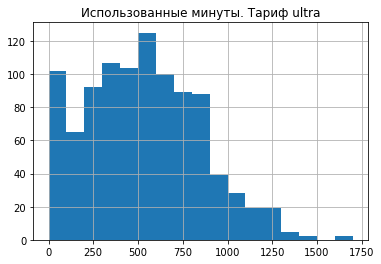

In [24]:
df_ultra['calls_sum'].hist(range=(10,100), bins=range(0, 1701, 100)); # по использованным минутам тариф ultra
print(df_ultra['calls_sum'].describe())

plt.title('Использованные минуты. Тариф ultra')

mean_calls_sum_ultra = df_ultra['calls_sum'].mean()
print('Среднее колчество', mean_calls_sum_ultra)

var_calls_sum_ultra = np.var(df_ultra['calls_sum'], ddof=1)# дисперсия выборки, т.к. нам дана выборка клиентов
print('Дисперсия', var_calls_sum_ultra)

std_calls_sum_ultra = np.sqrt(var_calls_sum_ultra)
print('Стандартное отклонение', std_calls_sum_ultra)

count     986.000000
mean      526.089249
std       317.887549
min         0.000000
25%       282.500000
50%       518.000000
75%       751.750000
max      1673.000000
Name: calls_sum, dtype: float64
Среднее колчество 526.0892494929006
Дисперсия 101052.49354928375
Стандартное отклонение 317.88754859113897


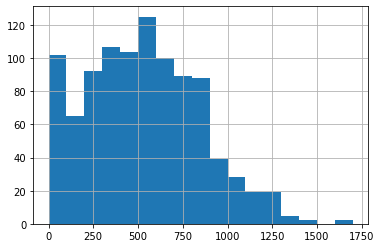

In [25]:
# Код ревьюера

df_ultra['calls_sum'].hist(range=(10,100), bins=range(0, 1701, 100)); # по использованным минутам тариф ultra
print(df_ultra['calls_sum'].describe())

mean_calls_sum_ultra = df_ultra['calls_sum'].mean()
print('Среднее колчество', mean_calls_sum_ultra)

var_calls_sum_ultra = np.var(df_ultra['calls_sum'], ddof=1)# дисперсия выборки, т.к. нам дана выборка клиентов
print('Дисперсия', var_calls_sum_ultra)

std_calls_sum_ultra = np.sqrt(var_calls_sum_ultra)
print('Стандартное отклонение', std_calls_sum_ultra)

Для количества потраченных минут (непрерывной переменной) посторим гистограмму частот указав границы интревалов. Распределение стремиться к нормальному(среднее значение и медиана близки).

count    986.000000
mean      49.313387
std       47.806040
min        0.000000
25%        6.000000
50%       38.000000
75%       78.750000
max      224.000000
Name: messages_quantity, dtype: float64
Среднее количество 49.31338742393509
Дисперсия 2285.417424655839
Стандартное отклонение 47.80603962530089


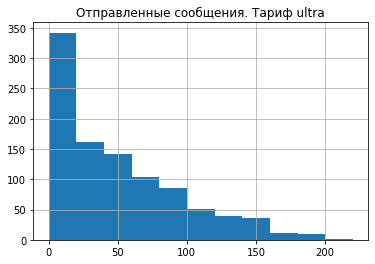

In [26]:
df_ultra['messages_quantity'].hist(range=(10,100), bins=range(0, 240, 20)); # по отправленным сообщениям тариф ultra
print(df_ultra['messages_quantity'].describe())
plt.title('Отправленные сообщения. Тариф ultra')

mean_messages_ultra = df_ultra['messages_quantity'].mean()
print('Среднее количество', mean_messages_ultra)


var_messages_quantity_ultra = np.var(df_ultra['messages_quantity'], ddof=1)
print('Дисперсия', var_messages_quantity_ultra)

std_messages_quantity_ultra = np.sqrt(var_messages_quantity_ultra)
print('Стандартное отклонение', std_messages_quantity_ultra)

Для количества отправленных сообщений (непрерывной переменной) посторим гистограмму частот указав границы интревалов. Распределение скошенно вправо.

count    986.000000
mean      19.474645
std        9.868057
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64
Среднее количество 19.474645030425965
Дисперсия 97.3785442901125
Стандартное отклонение 9.868056763624361


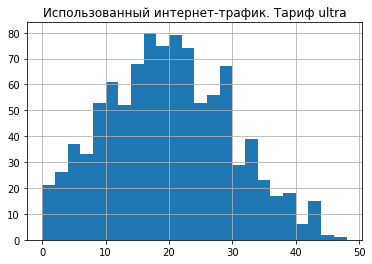

In [27]:
df_ultra['gb_used'].hist(range=(10,100), bins=range(0, 50, 2)); # по использованному интернет-трафику тариф ultra
print(df_ultra['gb_used'].describe())
plt.title('Использованный интернет-трафик. Тариф ultra')

mean_gb_used_ultra = df_ultra['gb_used'].mean()
print('Среднее количество', mean_gb_used_ultra)

var_gb_used_ultra = np.var(df_ultra['gb_used'], ddof=1)
print('Дисперсия', var_gb_used_ultra)

std_gb_used_ultra = np.sqrt(var_gb_used_ultra)
print('Стандартное отклонение', std_gb_used_ultra)

Для количества использованного интернет-трафика (непрерывной переменной) посторим гистограмму частот указав границы интревалов. Распределение стремится к нормальному (медиана и среднее почти равны).

count    986.000000
mean      73.318458
std       43.956739
min        0.000000
25%       41.000000
50%       73.500000
75%      103.750000
max      244.000000
Name: calls_quantity, dtype: float64
Среднее количество 73.3184584178499
Дисперсия 1932.194927976439
Стандартное отклонение 43.95673927825447


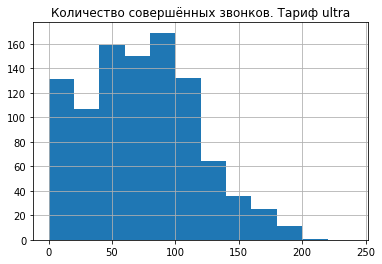

In [28]:
df_ultra['calls_quantity'].hist(range=(10,100), bins=range(0, 250, 20)); # по количеству совершённых звонков  тариф ultra
print(df_ultra['calls_quantity'].describe())
plt.title('Количество совершённых звонков. Тариф ultra')

mean_calls_quantity_ultra = df_ultra['calls_quantity'].mean()
print('Среднее количество', mean_calls_quantity_ultra)

var_calls_quantity_ultra = np.var(df_ultra['calls_quantity'], ddof=1)
print('Дисперсия', var_calls_quantity_ultra)

std_calls_quantity_ultra = np.sqrt(var_calls_quantity_ultra)
print('Стандартное отклонение', std_calls_quantity_ultra)

Для количества звонков (непрерывной переменной) посторим гистограмму частот указав границы интревалов. Распределение стремится к нормальному (медиана и среднее почти равны).

,user_id
city,
Москва,32
Санкт-Петербург,9
Уфа,6
Краснодар,5
Новосибирск,5
Воронеж,5
Пенза,5
Омск,4
Набережные Челны,4


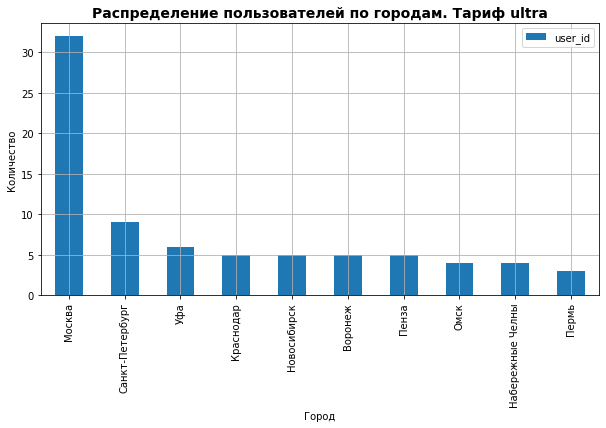

In [29]:
(data_users 
 .query('tariff == "ultra"')    # распределение пользователей по городам
 .pivot_table(index='city', values='user_id', aggfunc='count')
 .sort_values('user_id', ascending=False)[0:10]                # 10 с наибольшим количеством абонентов с тарифом ultra
 .plot(kind='bar', grid=True, figsize=(10, 5))
); 
plt.title('Распределение пользователей по городам. Тариф ultra', fontsize=14, fontweight="bold")
plt.xlabel('Город')
plt.ylabel('Количество')
display(data_users.query('tariff == "ultra"').pivot_table(index='city', values='user_id', aggfunc='count').round().sort_values('user_id', ascending=False)[0:10])  

***Вывод по анализу абонентов трифа ultra***

Разделив клиентов по тарифу можно сказать, что большая часть клиентов с тарифом ultra оплачивает в месяц только абонентскую плату.

Абоненты с тарифом "ultra" в среднем тратят на разговоры 545 минут, совершают 76 звонков, отправляют 49 сообщений и используют около 19.5 Гб интернет-трафика. Средние значения значительно ниже предоставляемых оператором за абоненскую плату.

Большая часть этих клиентов из Москвы, почти в 3 раза больше, чем в следующем по частоте Санкт-Перетбурге. В остальных городах тариф явно не пользуется популярностью. 

count    2230.000000
mean      417.747534
std       190.476754
min         0.000000
25%       282.000000
50%       421.500000
75%       545.000000
max      1435.000000
Name: calls_sum, dtype: float64
Среднее колчество 417.747533632287
Дисперсия 36281.393836444564
Стандартное отклонение 190.47675405792845


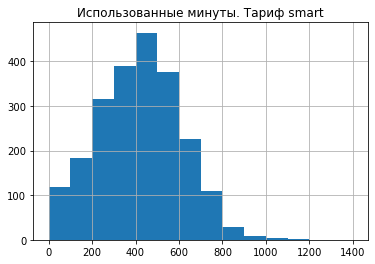

In [30]:
df_smart['calls_sum'].hist(range=(10,100), bins=range(0, 1435, 100)); # по использованным минутам тариф smart
print(df_smart['calls_sum'].describe())
plt.title('Использованные минуты. Тариф smart')

mean_calls_sum_smart = df_smart['calls_sum'].mean()
print('Среднее колчество', mean_calls_sum_smart)

var_calls_sum_smart = np.var(df_smart['calls_sum'], ddof=1)
print('Дисперсия', var_calls_sum_smart)

std_calls_sum_smart = np.sqrt(var_calls_sum_smart)
print('Стандартное отклонение', std_calls_sum_smart)

Для количества потраченных минут (непрерывной переменной) посторим гистограмму частот указав границы интревалов. Распределение стремиться к нормальному(среднее значение и медиана очень близки).

count    2230.000000
mean       33.369058
std        28.230396
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_quantity, dtype: float64
Среднее количество 33.36905829596412
Дисперсия 796.9552557301104
Стандартное отклонение 28.230395954185806


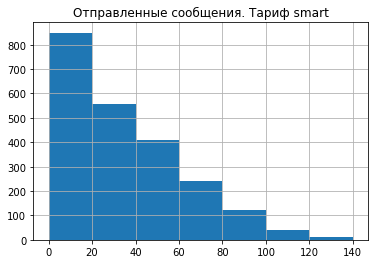

In [31]:
df_smart['messages_quantity'].hist(range=(10,100), bins=range(0, 145, 20)); # по отправленным сообщениям тариф smart
print(df_smart['messages_quantity'].describe())
plt.title('Отправленные сообщения. Тариф smart')

mean_messages_smart = df_smart['messages_quantity'].mean()
print('Среднее количество', mean_messages_smart)


var_messages_smart = np.var(df_smart['messages_quantity'], ddof=1)
print('Дисперсия', var_messages_smart)

std_messages_smart = np.sqrt(var_messages_smart)
print('Стандартное отклонение', std_messages_smart)

Для количества отправленных сообщений (непрерывной переменной) посторим гистограмму частот указав границы интревалов. Распределение скошенно вправо.

count    2230.000000
mean       16.321525
std         5.756167
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64
Среднее количество 16.32152466367713
Дисперсия 33.13345303550617
Стандартное отклонение 5.756166522565706


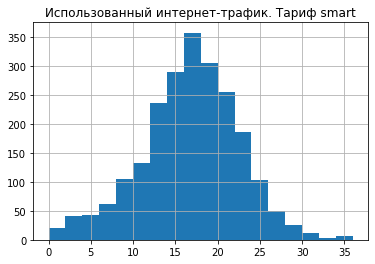

In [32]:
df_smart['gb_used'].hist(range=(10,100), bins=range(0, 38, 2)); # по использованному интернет-трафику тариф smart
print(df_smart['gb_used'].describe())
plt.title('Использованный интернет-трафик. Тариф smart')

mean_gb_used_smart = df_smart['gb_used'].mean()
print('Среднее количество', mean_gb_used_smart)

var_gb_used_smart = np.var(df_smart['gb_used'], ddof=1)
print('Дисперсия', var_gb_used_smart)

std_gb_used_smart = np.sqrt(var_gb_used_smart)
print('Стандартное отклонение', std_gb_used_smart)

Для количества использованного интернет-трафика (непрерывной переменной) посторим гистограмму частот указав границы интревалов. Распределение стремится к нормальному (медиана и среднее близки по значению).

count    2230.000000
mean       58.437220
std        25.963572
min         0.000000
25%        40.000000
50%        60.000000
75%        76.000000
max       198.000000
Name: calls_quantity, dtype: float64
Среднее количество 58.437219730941706
Дисперсия 674.1070932087628
Стандартное отклонение 25.96357242770653


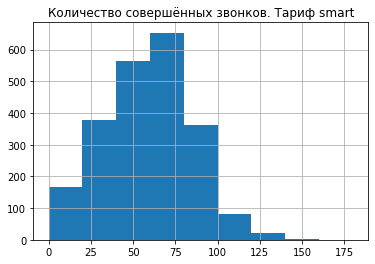

In [33]:
df_smart['calls_quantity'].hist(range=(10,100), bins=range(0, 198, 20)); # по количеству соверщённых звонков  тариф smart
print(df_smart['calls_quantity'].describe())
plt.title('Количество совершённых звонков. Тариф smart')

mean_calls_quantity_smart = df_smart['calls_quantity'].mean()
print('Среднее количество', mean_calls_quantity_smart)

var_calls_quantity_smart = np.var(df_smart['calls_quantity'], ddof=1)
print('Дисперсия', var_calls_quantity_smart)

std_calls_quantity_smart = np.sqrt(var_calls_quantity_smart)
print('Стандартное отклонение', std_calls_quantity_smart)

Для количества звонков (непрерывной переменной) посторим гистограмму частот указав границы интревалов. Распределение стремится к нормальному (медиана и среднее близки по значению).

,user_id
city,
Москва,67
Санкт-Петербург,30
Казань,13
Новосибирск,11
Омск,10
Ульяновск,10
Екатеринбург,9
Улан-Удэ,7
Самара,7


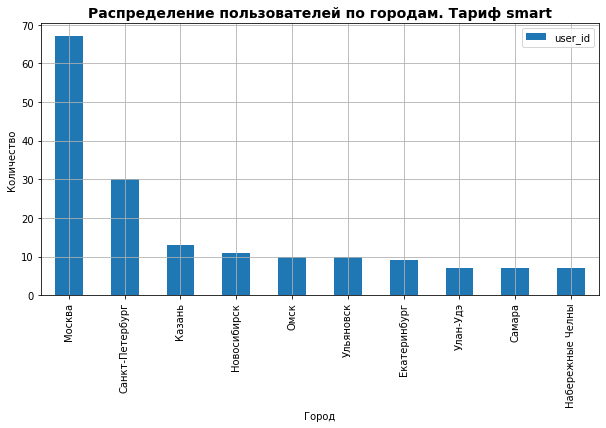

In [34]:
(data_users 
 .query('tariff == "smart"')    # распределение пользователей по городам
 .pivot_table(index='city', values='user_id', aggfunc='count')
 .sort_values('user_id', ascending=False)[0:10]                # 10 с наибольшим количеством абонентов с тарифом ultra
 .plot(kind='bar', grid=True, figsize=(10, 5))
); 
plt.title('Распределение пользователей по городам. Тариф smart', fontsize=14, fontweight="bold")
plt.xlabel('Город')
plt.ylabel('Количество')
display(data_users.query('tariff == "smart"').pivot_table(index='city', values='user_id', aggfunc='count').round().sort_values('user_id', ascending=False)[0:10])  

***Вывод по анализу абонентов трифа smart***

Разделив клиентов по тарифу можно сказать, что тарифом "smart" пользуется большее число абонентов и по большей части их платежи выходят за рамки абонентской платы.

Абоненты с тарифом "smart" в среднем тратят на разговоры 419 минут, совершают 58 звонков, отправляют 33 сообщения и используют около 16 Гб интернет-трафика. Средние значения звонков и сообщений в пределах предоставляемых оператором за абоненскую плату, а вот среднее значение использованного интернет-трафика выбивается.

Большая часть этих клиентов так же из Москвы, но разница с Санкт_Перебрургом меньше, чем при сравнении тарифа "ultra". 

Численно значения средней и медианной длительности звонков, их количества, число отправленных сообщений и использованных Гб по пользователям разных тарифов отличается, но распределение этих значений очень схоже.

### Шаг 4 Проверка гипотез.

***Проверим первую гипотезу:***
- средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются

Сформулируем нулевую гипотезу H₀: средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт". H₀ всегда формулируется так, чтобы использовать знак равенства.

Исходя из H₀ формулируем альтернативную гипотезу H₁: средняя выручка пользователей тарифа "Ультра" не равна средней выручке  пользователей тарифа "Смарт". Такая альтернативная гипотеза называется двусторонней, потому что есть возможное отклонение и в большую, и в меньшую стороны.

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам используем метод: scipy.stats.ttest_ind (array1, array2,equal_var). Параметр equal_var = False, т.к. выборки разные по размерам.
Критический уровень статистической значимости зададим 5%.

In [35]:
print(df_ultra['cost'].describe()) # выручка пользователей тарифа Ультра

count     986.000000
mean     2070.030426
std       376.015578
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: cost, dtype: float64


In [36]:
print(df_smart['cost'].describe()) # выручка пользователей тарифа Смарт

count    2230.000000
mean     1289.641704
std       818.370799
min       550.000000
25%       550.000000
50%      1021.000000
75%      1750.000000
max      6770.000000
Name: cost, dtype: float64


In [37]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    df_ultra['cost'], 
    df_smart['cost'],
    equal_var = False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Cредняя выручка пользователей тарифов Ультра и Смарт различаются.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Средняя выручка пользователей тарифа Ультра равна средней выручке пользователей тарифа Смарт') 

p-значение:  1.927011394420941e-250
Отвергаем нулевую гипотезу. Cредняя выручка пользователей тарифов Ультра и Смарт различаются.


Нулевая гипотезе не подтвердилась. Уровень значимости сильно меньше заданного уровня статистической значимости. Нулевая гипотеза отвергается в пользу альтернативной - Cредняя выручка пользователей тарифов Ультра и Смарт различаются.

***Проверим вторую гипотезу:***
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем нулевую гипотезу H₀: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. H₀ всегда формулируется так, чтобы использовать знак равенства.

Исходя из H₀ формулируем альтернативную гипотезу H₁: средняя выручка пользователей из Москвы не равна средней выручке  пользователей из других регионов. Такая альтернативная гипотеза называется двусторонней, потому что есть возможное отклонение и в большую, и в меньшую стороны.

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам так же используем метод: scipy.stats.ttest_ind (array1, array2,equal_var). Параметр equal_var = False, т.к. выборки разные по размерам.
Критический уровень статистической значимости зададим 5%.

In [38]:
df_moscow = df.query('city == "Москва"') # выборка по Москве
display(df_moscow.head(10), df_moscow.describe())
len(df_moscow['user_id'].unique())

,user_id,month,tariff,rub_monthly_fee,cost,calls_sum,calls_quantity,messages_quantity,gb_used,city
8,1001,11.0,smart,550,1150.0,430.0,59.0,0.0,18.0,Москва
9,1001,12.0,smart,550,550.0,414.0,63.0,0.0,14.0,Москва
17,1003,8.0,ultra,1950,1950.0,380.0,55.0,37.0,9.0,Москва
18,1003,9.0,ultra,1950,1950.0,961.0,134.0,91.0,13.0,Москва
19,1003,10.0,ultra,1950,1950.0,855.0,108.0,83.0,15.0,Москва
20,1003,11.0,ultra,1950,1950.0,824.0,115.0,94.0,12.0,Москва
21,1003,12.0,ultra,1950,1950.0,802.0,108.0,75.0,10.0,Москва
53,1007,4.0,smart,550,550.0,198.0,25.0,11.0,8.0,Москва
54,1007,5.0,smart,550,1150.0,480.0,67.0,39.0,18.0,Москва
55,1007,6.0,smart,550,685.0,545.0,68.0,26.0,14.0,Москва


,user_id,month,rub_monthly_fee,cost,calls_sum,calls_quantity,messages_quantity,gb_used
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,1268.872340,8.432079,1065.548282,1546.713584,469.150573,65.436989,37.877250,18.050736
std,137.530432,2.888057,675.814374,752.088071,241.535044,33.186021,37.160304,7.645788
min,1001.000000,1.000000,550.000000,550.000000,0.000000,0.000000,0.000000,1.000000
25%,1171.000000,6.000000,550.000000,780.500000,304.000000,42.000000,6.500000,13.000000
50%,1291.000000,9.000000,550.000000,1750.000000,453.000000,64.000000,29.000000,18.000000
75%,1385.000000,11.000000,1950.000000,1950.000000,620.500000,85.500000,57.000000,22.000000
max,1490.000000,12.000000,1950.000000,5321.000000,1321.000000,188.000000,191.000000,44.000000


99

In [39]:
df_other = df.query('city != "Москва"') # выборка по всем городам кроме Москвы
display(df_other.head(10), df_other.describe())

,user_id,month,tariff,rub_monthly_fee,cost,calls_sum,calls_quantity,messages_quantity,gb_used,city
0,1000,5.0,ultra,1950,1950.0,159.0,22.0,22.0,3.0,Краснодар
1,1000,6.0,ultra,1950,1950.0,172.0,43.0,60.0,23.0,Краснодар
2,1000,7.0,ultra,1950,1950.0,340.0,47.0,75.0,14.0,Краснодар
3,1000,8.0,ultra,1950,1950.0,408.0,52.0,81.0,14.0,Краснодар
4,1000,9.0,ultra,1950,1950.0,466.0,58.0,57.0,15.0,Краснодар
5,1000,10.0,ultra,1950,1950.0,350.0,57.0,73.0,15.0,Краснодар
6,1000,11.0,ultra,1950,1950.0,338.0,43.0,58.0,15.0,Краснодар
7,1000,12.0,ultra,1950,1950.0,333.0,46.0,70.0,10.0,Краснодар
10,1002,6.0,smart,550,550.0,117.0,15.0,4.0,11.0,Стерлитамак
11,1002,7.0,smart,550,1150.0,214.0,26.0,11.0,18.0,Стерлитамак


,user_id,month,rub_monthly_fee,cost,calls_sum,calls_quantity,messages_quantity,gb_used
count,2605.000000,2605.000000,2605.000000,2605.000000,2605.000000,2605.000000,2605.000000,2605.000000
mean,1247.535125,8.284069,958.982726,1524.725144,446.698656,62.428023,38.346641,17.109405
std,145.994150,2.917306,636.761018,808.745680,242.076254,33.261761,35.915233,7.344701
min,1000.000000,0.000000,550.000000,550.000000,0.000000,0.000000,0.000000,0.000000
25%,1120.000000,6.000000,550.000000,750.000000,280.000000,39.000000,9.000000,13.000000
50%,1241.000000,9.000000,550.000000,1583.000000,440.000000,62.000000,30.000000,17.000000
75%,1377.000000,11.000000,1950.000000,1950.000000,584.000000,82.000000,57.000000,21.000000
max,1499.000000,12.000000,1950.000000,6770.000000,1673.000000,244.000000,224.000000,49.000000


In [40]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    df_moscow['cost'], 
    df_other['cost'],
    equal_var = False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.') 

p-значение:  0.5216952110000279
Не получилось отвергнуть нулевую гипотезу. Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.


Нулевую гипотезу не удалось отвергнуть. Уровень значимости сильно выше заданного уровня статистической значимости. Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

### Шаг 4 Вывод.

По итогу проведённого анализа можно сказать, что:

- большая часть клиентов с тарифом Ультра оплачивает в месяц только абонентскую плату (медианное значение ёё 1950, что равно сумме ежемесячного абонентского платежа)
- тарифом Смарт пользуется большее число абонентов и по большей части их платежи выходят за рамки абонентской платы (медиана 1021, при ежемесячном обязательном платеже 550)
- абоненты с тарифом Ультра в среднем тратят на разговоры 545 минут, совершают 76 звонков, отправляют 49 сообщений и используют около 19.5 Гб интернет-трафика. Средние значения значительно ниже предоставляемых оператором за абоненскую плату.
- абоненты с тарифом Смарт в среднем тратят на разговоры 419 минут, совершают 58 звонков, отправляют 33 сообщения и используют около 16 Гб интернет-трафика. Средние значения звонков и сообщений в пределах предоставляемых оператором за абоненскую плату, а вот среднее значение использованного интернет-трафика выбивается. 
- Большая часть абонентов обоих тарифов из Москвы. По данным выборки из 500 абонентов 99 из Москвы, из них 32 абонента тарифа Ультра и 67 - тарифа Смарт
- гипотезу о том, что средняя выручка пользователей по тарифам различается на основе предоставленным данных мы не смогли опровергнуть. По абонентам тарифа Ультра средняя выручка составила 2070, а по абонентам тарифа Смарт средняя выручка - 1289
- гипотеза о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей других регионов не подтвердилась. По абонентам из Москвы средняя выручка составила 1546, а по абонентам всех остальных городов средняя выручка - 1524, что отличается примерно на 1.5%

В ходе проведённого исследования не проводилось замены и удаления значений выборки.